Theory : https://towardsdatascience.com/understanding-random-forest-58381e0602d2

Examples : https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

# Probability of surges

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import geopandas as gpd
from shapely.geometry import Polygon

import matplotlib.pyplot as plt

from sklearn.utils import resample

### Set random seed to ensure reproducible runs

In [2]:
RSEED = 50

### Importing data and data cleaning

In [3]:
df_main = pd.read_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/df_main.csv', index_col=['rgiid', 'x', 'y'])
df_main

Unnamed: 0  Surge   Area  Slope  \
rgiid          x             y                                               
RGI60-07.00004 524657.521964 8.539931e+06         206      0  1.044   13.8   
               524681.113471 8.539955e+06         207      0  1.044   13.8   
               524704.704977 8.539980e+06         208      0  1.044   13.8   
               524728.296484 8.540004e+06         209      0  1.044   13.8   
               524751.887990 8.540028e+06         210      0  1.044   13.8   
...                                               ...    ...    ...    ...   
RGI60-07.01567 534269.488654 8.675206e+06      130984      3  5.350   11.7   
               534310.362510 8.675249e+06      130985      3  5.350   11.7   
               534309.250485 8.675291e+06      130986      3  5.350   11.7   
               534308.138459 8.675333e+06      130987      3  5.350   11.7   
               534307.026431 8.675375e+06      130988      3  5.350   11.7   

                                           TermType          Name        bed  \
rgiid          x             y                                                 
RGI60-07.00004 524657.521964 8.539931e+06         0           NaN  889.68555   
               524681.113471 8.539955e+06         0           NaN  882.06460   
               524704.704977 8.539980e+06         0           NaN  882.06460   
               524728.296484 8.540004e+06         0           NaN  882.06460   
               524751.887990 8.540028e+06         0           NaN  881.31860   
...                                             ...           ...        ...   
RGI60-07.01567 534269.488654 8.675206e+06         0  Moeysalbreen  237.64468   
               534310.362510 8.675249e+06         0  Moeysalbreen  233.07228   
               534309.250485 8.675291e+06         0  Moeysalbreen  233.07228   
               534308.138459 8.675333e+06         0  Moeysalbreen  233.18828   
               534307.026431 8.675375e+06         0  Moeysalbreen  233.18828   

                                           thickness  surface_elevation  \
rgiid          x             y                                            
RGI60-07.00004 524657.521964 8.539931e+06  25.314478          915.00000   
               524681.113471 8.539955e+06  30.935455          913.00000   
               524704.704977 8.539980e+06  30.935455          913.00000   
               524728.296484 8.540004e+06  30.935455          913.00000   
               524751.887990 8.540028e+06  34.681380          916.00000   
...                                              ...                ...   
RGI60-07.01567 534269.488654 8.675206e+06  50.380424          288.02512   
               534310.362510 8.675249e+06  46.717087          279.78937   
               534309.250485 8.675291e+06  46.717087          279.78937   
               534308.138459 8.675333e+06  47.159560          280.34784   
               534307.026431 8.675375e+06  47.159560          280.34784   

                                                  ELA      beta       cmb  \
rgiid          x             y                                              
RGI60-07.00004 524657.521964 8.539931e+06  432.103017  0.005069  1.392706   
               524681.113471 8.539955e+06  432.421537  0.005068  1.391001   
               524704.704977 8.539980e+06  432.740057  0.005068  1.389296   
               524728.296484 8.540004e+06  433.058576  0.005067  1.387591   
               524751.887990 8.540028e+06  433.377096  0.005067  1.385886   
...                                               ...       ...       ...   
RGI60-07.01567 534269.488654 8.675206e+06  627.625366  0.004612 -1.412920   
               534310.362510 8.675249e+06  627.625366  0.004614 -1.423469   
               534309.250485 8.675291e+06  627.625366  0.004618 -1.395654   
               534308.138459 8.675333e+06  627.625366  0.004620 -1.382369   
               534307.026431 8.675375e+06  627.625366  0.004621 -1.369084   

         

In [4]:
df_main['SMB_calc'] = df_main['beta']*(df_main['surface_elevation']-df_main['ELA'])
df_main

Unnamed: 0  Surge   Area  Slope  \
rgiid          x             y                                               
RGI60-07.00004 524657.521964 8.539931e+06         206      0  1.044   13.8   
               524681.113471 8.539955e+06         207      0  1.044   13.8   
               524704.704977 8.539980e+06         208      0  1.044   13.8   
               524728.296484 8.540004e+06         209      0  1.044   13.8   
               524751.887990 8.540028e+06         210      0  1.044   13.8   
...                                               ...    ...    ...    ...   
RGI60-07.01567 534269.488654 8.675206e+06      130984      3  5.350   11.7   
               534310.362510 8.675249e+06      130985      3  5.350   11.7   
               534309.250485 8.675291e+06      130986      3  5.350   11.7   
               534308.138459 8.675333e+06      130987      3  5.350   11.7   
               534307.026431 8.675375e+06      130988      3  5.350   11.7   

                                           TermType          Name        bed  \
rgiid          x             y                                                 
RGI60-07.00004 524657.521964 8.539931e+06         0           NaN  889.68555   
               524681.113471 8.539955e+06         0           NaN  882.06460   
               524704.704977 8.539980e+06         0           NaN  882.06460   
               524728.296484 8.540004e+06         0           NaN  882.06460   
               524751.887990 8.540028e+06         0           NaN  881.31860   
...                                             ...           ...        ...   
RGI60-07.01567 534269.488654 8.675206e+06         0  Moeysalbreen  237.64468   
               534310.362510 8.675249e+06         0  Moeysalbreen  233.07228   
               534309.250485 8.675291e+06         0  Moeysalbreen  233.07228   
               534308.138459 8.675333e+06         0  Moeysalbreen  233.18828   
               534307.026431 8.675375e+06         0  Moeysalbreen  233.18828   

                                           thickness  surface_elevation  \
rgiid          x             y                                            
RGI60-07.00004 524657.521964 8.539931e+06  25.314478          915.00000   
               524681.113471 8.539955e+06  30.935455          913.00000   
               524704.704977 8.539980e+06  30.935455          913.00000   
               524728.296484 8.540004e+06  30.935455          913.00000   
               524751.887990 8.540028e+06  34.681380          916.00000   
...                                              ...                ...   
RGI60-07.01567 534269.488654 8.675206e+06  50.380424          288.02512   
               534310.362510 8.675249e+06  46.717087          279.78937   
               534309.250485 8.675291e+06  46.717087          279.78937   
               534308.138459 8.675333e+06  47.159560          280.34784   
               534307.026431 8.675375e+06  47.159560          280.34784   

                                                  ELA      beta       cmb  \
rgiid          x             y                                              
RGI60-07.00004 524657.521964 8.539931e+06  432.103017  0.005069  1.392706   
               524681.113471 8.539955e+06  432.421537  0.005068  1.391001   
               524704.704977 8.539980e+06  432.740057  0.005068  1.389296   
               524728.296484 8.540004e+06  433.058576  0.005067  1.387591   
               524751.887990 8.540028e+06  433.377096  0.005067  1.385886   
...                                               ...       ...       ...   
RGI60-07.01567 534269.488654 8.675206e+06  627.625366  0.004612 -1.412920   
               534310.362510 8.675249e+06  627.625366  0.004614 -1.423469   
               534309.250485 8.675291e+06  627.625366  0.004618 -1.395654   
               534308.138459 8.675333e+06  627.625366  0.004620 -1.382369   
               534307.026431 8.675375e+06  627.625366  0.004621 -1.369084   

         

In [5]:
df_main['WH'] = df_main['width_centerline'] / df_main['thickness']
df_main['WHsin'] = df_main['thickness']*df_main['width_centerline']*np.sin(df_main['Slope'])
df_main['dummy'] = np.random.rand(df_main.shape[0])

In [6]:
df = df_main.drop(df_main[df_main['Surge']==9].index)
df = df.drop(df_main[df_main['Surge']==1].index)
# df = df_main.drop(df_main[df_main['Surge']==2].index)
df = df.drop(columns = ['Unnamed: 0', 'ELA', 'beta', 'Name', 'Area', 'cmb'])
df.dropna(how='any', inplace=True)

In [7]:
df.groupby('Surge').count()

,Slope,TermType,bed,thickness,surface_elevation,width_centerline,Runoff,SMB_calc,WH,WHsin,dummy
Surge,,,,,,,,,,,
0,68675,68675,68675,68675,68675,68675,68675,68675,68675,68675,68675
2,4249,4249,4249,4249,4249,4249,4249,4249,4249,4249,4249
3,10897,10897,10897,10897,10897,10897,10897,10897,10897,10897,10897


In [8]:
df['Surge'] = df['Surge'].replace({3: 1, 2:1})
df = df.loc[df['Surge'].isin([0, 1])].copy()
df = df.rename(columns = {'Surge': 'label'})
df['label'].value_counts()

0    68675
1    15146
Name: label, dtype: int64

In [9]:
df[df['label']==1].shape[0]

15146

In [10]:
df.shape

(83821, 12)

### Resampled

In [11]:
# Separate majority and minority classes
df_majority = df[df['label']==0]
df_minority = df[df['label']==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df[df['label']==1].shape[0],     # to match minority class
                                 random_state=RSEED) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['label'].value_counts()
df = df_downsampled

In [12]:
df_downsampled.shape

(30292, 12)

In [13]:
# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

In [14]:
train_labels.sum()/train_labels.shape[0]

0.5

In [15]:
test_labels.sum()/test_labels.shape[0]

0.5

In [16]:
# Features for feature importances
features = list(train.columns)
features

['Slope',
 'TermType',
 'bed',
 'thickness',
 'surface_elevation',
 'width_centerline',
 'Runoff',
 'SMB_calc',
 'WH',
 'WHsin',
 'dummy']

In [17]:
train.head()

,,,Slope,TermType,bed,thickness,surface_elevation,width_centerline,Runoff,SMB_calc,WH,WHsin,dummy
rgiid,x,y,,,,,,,,,,,
RGI60-07.00515,441975.150359,8.727522e+06,19.5,0,264.174900,38.879795,303.0547,576.297132,2.549741,-1.518291,14.822535,13567.916665,0.685089
RGI60-07.00873,548147.700372,8.772440e+06,7.4,0,1034.511800,81.036380,1115.5482,4308.036475,0.253687,0.200014,53.161759,313745.899081,0.287366
RGI60-07.00859,530846.114530,8.837916e+06,9.1,1,579.684600,214.568920,794.2535,7218.261007,0.504620,0.259796,33.640758,494224.160475,0.082296
RGI60-07.00315,578764.810581,8.620960e+06,9.4,1,-28.271210,97.271210,69.0000,2263.341551,2.532262,-1.377222,23.268360,5454.507405,0.179656
RGI60-07.00233,514508.764759,8.598699e+06,10.7,0,-33.664413,150.664410,117.0000,864.509164,3.193687,-3.300643,5.737979,-124602.440895,0.587507


In [18]:
train_labels.shape

(21204,)

In [19]:
test.head()

,,,Slope,TermType,bed,thickness,surface_elevation,width_centerline,Runoff,SMB_calc,WH,WHsin,dummy
rgiid,x,y,,,,,,,,,,,
RGI60-07.00465,478371.303131,8.716493e+06,8.1,1,46.214294,221.83762,268.05190,5613.527053,2.654832,-1.401845,25.304667,1.207796e+06,0.554090
RGI60-07.01090,489770.321036,8.649560e+06,10.6,0,147.998780,71.05932,219.05810,645.227888,1.370421,-1.918945,9.080130,-4.230875e+04,0.883679
RGI60-07.00406,557921.341535,8.663047e+06,12.2,0,184.157470,48.18905,232.34653,619.202874,2.521803,-1.821770,12.849452,-1.068913e+04,0.201146
RGI60-07.00862,541092.973415,8.860543e+06,9.7,0,165.962950,90.94358,256.90652,276.764792,1.145731,-0.664016,3.043258,-6.840210e+03,0.707244
RGI60-07.00169,530699.535153,8.626463e+06,14.4,0,551.148100,41.85196,593.00000,1038.449988,1.399670,0.206295,24.812458,4.196861e+04,0.291264


# Gradient boosting

### Only 4 values (Term, thickness, runoff, width)

In [20]:
import xgboost
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [21]:
train.columns

Index(['Slope', 'TermType', 'bed', 'thickness', 'surface_elevation',
       'width_centerline', 'Runoff', 'SMB_calc', 'WH', 'WHsin', 'dummy'],
      dtype='object')

In [22]:
train_reduced = train.drop(columns=['Slope', 'bed', 'surface_elevation', 'SMB_calc', 'WH', 'WHsin', 'dummy'])
test_reduced = test.drop(columns=['Slope', 'bed', 'surface_elevation', 'SMB_calc', 'WH', 'WHsin', 'dummy'])

In [23]:
test

,,,Slope,TermType,bed,thickness,surface_elevation,width_centerline,Runoff,SMB_calc,WH,WHsin,dummy
rgiid,x,y,,,,,,,,,,,
RGI60-07.00465,478371.303131,8.716493e+06,8.1,1,46.214294,221.837620,268.05190,5613.527053,2.654832,-1.401845,25.304667,1.207796e+06,0.554090
RGI60-07.01090,489770.321036,8.649560e+06,10.6,0,147.998780,71.059320,219.05810,645.227888,1.370421,-1.918945,9.080130,-4.230875e+04,0.883679
RGI60-07.00406,557921.341535,8.663047e+06,12.2,0,184.157470,48.189050,232.34653,619.202874,2.521803,-1.821770,12.849452,-1.068913e+04,0.201146
RGI60-07.00862,541092.973415,8.860543e+06,9.7,0,165.962950,90.943580,256.90652,276.764792,1.145731,-0.664016,3.043258,-6.840210e+03,0.707244
RGI60-07.00169,530699.535153,8.626463e+06,14.4,0,551.148100,41.851960,593.00000,1038.449988,1.399670,0.206295,24.812458,4.196861e+04,0.291264
...,...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01164,490373.714054,8.827258e+06,11.0,0,779.663400,29.336622,809.00000,610.638536,1.196574,-0.154676,20.814889,-1.791390e+04,0.098276
RGI60-07.00244,517785.529431,8.572797e+06,8.7,1,159.438140,326.561860,486.00000,3647.614162,1.632135,-0.321394,11.169749,7.897102e+05,0.832826
RGI60-07.01324,438854.874150,8.849988e+06,28.3,0,390.872800,21.127195,412.00000,384.196907,2.246294,-0.467437,18.184946,-2.083091e+02,0.238669


In [24]:
dmatrix_train = xgboost.DMatrix(train_reduced, label=train_labels)
dmatrix_test = xgboost.DMatrix(test_reduced, label=test_labels)

In [25]:
# params = {'objective':'reg:logistic', 'num_boost_round':20000, 'max_depth':1, 'scale_pos_weight':0.5}
params = {'objective':'reg:logistic', 'max_depth':1, 'scale_pos_weight':0.5}
xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)

# xgb = xgboost.XGBClassifier(**params)
# xgb.fit(train_reduced, train_labels)
# xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)

Text(0.6, 0.0, 'AUC = 0.8')

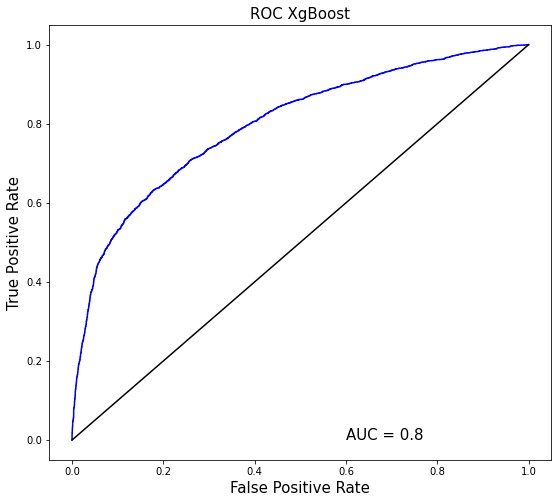

In [26]:
predictions_xgboost = xgb.predict(dmatrix_test)
fpr, tpr, t = metrics.roc_curve(y_true=test_labels, y_score=predictions_xgboost)

fig, ax = plt.subplots(figsize=(9, 8))

ax.plot(fpr, tpr, 'b')
ax.plot([0, 1], [0, 1], 'k')

ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_title('ROC XgBoost', fontsize=15)
ax.text(
s = 'AUC = ' + str(round(metrics.roc_auc_score(y_true=test_labels, y_score=predictions_xgboost),2))
    , x=0.6, y=0.0, fontsize=15
)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

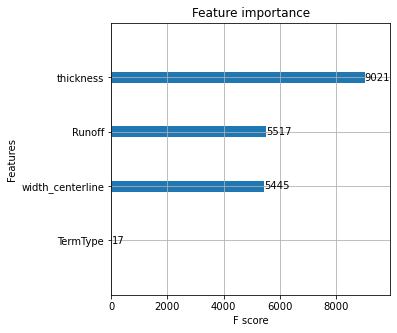

In [27]:
fig, ax = plt.subplots(figsize=(5, 5))
xgboost.plot_importance(xgb, ax=ax)

In [28]:
xgb = xgboost.XGBClassifier(**params)
xgb.fit(train_reduced, train_labels)

/home/colili/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=0.5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
rfe = RFE(xgb,2)
rfe = rfe.fit(train_reduced, train_labels)

print(rfe.support_)
print(rfe.ranking_)

/home/colili/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/colili/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/colili/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) 

[ True False  True False]
[1 2 1 3]


In [30]:
temp = pd.Series(rfe.support_,index = train_reduced.columns)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['TermType', 'width_centerline'], dtype='object')


### All database

In [31]:
dmatrix_train = xgboost.DMatrix(train, label=train_labels)
dmatrix_test = xgboost.DMatrix(test, label=test_labels)

In [32]:
params = {'objective':'reg:logistic', 'max_depth':1, 'scale_pos_weight':0.5}
xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)

Text(0.6, 0.0, 'AUC = 0.9')

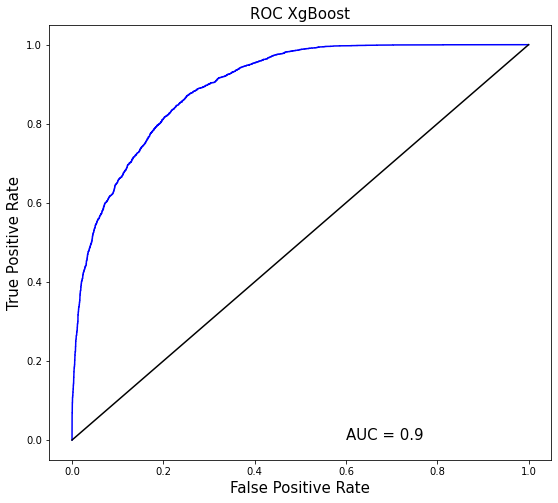

In [33]:
predictions_xgboost = xgb.predict(dmatrix_test)
fpr, tpr, t = metrics.roc_curve(y_true=test_labels, y_score=predictions_xgboost)

fig, ax = plt.subplots(figsize=(9, 8))

ax.plot(fpr, tpr, 'b')
ax.plot([0, 1], [0, 1], 'k')

ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_title('ROC XgBoost', fontsize=15)
ax.text(
s = 'AUC = ' + str(round(metrics.roc_auc_score(y_true=test_labels, y_score=predictions_xgboost),2))
    , x=0.6, y=0.0, fontsize=15
)

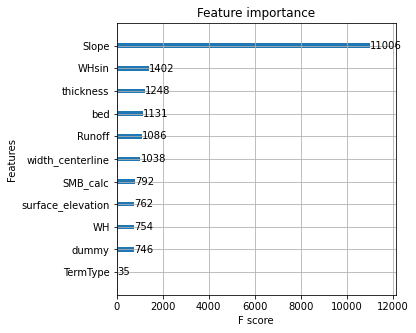

In [34]:
fig, ax = plt.subplots(figsize=(5, 5))
xgboost.plot_importance(xgb, ax=ax)
plt.savefig('/home/colili/Documents/PhD/project_john/Figure_produced/Raw/feature_importance_XGBoost.pdf', format='pdf', bbox_inches='tight')

In [35]:
xgb = xgboost.XGBClassifier(**params)
xgb.fit(train, train_labels)

/home/colili/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=0.5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
rfe = RFE(xgb,4)
rfe = rfe.fit(train_reduced, train_labels)

print(rfe.support_)
print(rfe.ranking_)

/home/colili/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=4 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/colili/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[ True  True  True  True]
[1 1 1 1]


In [37]:
temp = pd.Series(rfe.support_,index = train_reduced.columns)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['TermType', 'thickness', 'width_centerline', 'Runoff'], dtype='object')


### Recursively delete feature and rerun the model to see the AUC

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from numpy import sort

In [39]:
dmatrix_train = xgboost.DMatrix(train, label=train_labels)
dmatrix_test = xgboost.DMatrix(test, label=test_labels)

In [40]:
params = {'objective':'reg:logistic', 'max_depth':1, 'scale_pos_weight':0.5}
xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)

In [41]:
predictions_xgboost = xgb.predict(dmatrix_test)
fpr, tpr, t = metrics.roc_curve(y_true=test_labels, y_score=predictions_xgboost)

In [42]:
xgb = xgboost.XGBClassifier(**params)
xgb.fit(train, train_labels)

/home/colili/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=0.5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
import warnings
warnings.filterwarnings('ignore')

AUC=[]

# Fit model using each importance as a threshold
thresholds = sort(xgb.feature_importances_)
for thresh in thresholds:
    print(thresh)
    # select features using threshold
    selection = SelectFromModel(xgb, threshold=thresh, prefit=True)
    select_X_train = selection.transform(train)
    # train model
    selection_model = xgboost.XGBClassifier(**params)
    selection_model.fit(select_X_train, train_labels)
    # eval model
    select_X_test = selection.transform(test)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(test_labels, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    AUC.append(metrics.roc_auc_score(y_true=test_labels, y_score=predictions))


0.0
Thresh=0.000, n=11, Accuracy: 74.30%
0.0
Thresh=0.000, n=11, Accuracy: 74.30%
0.012293207
Thresh=0.012, n=9, Accuracy: 74.30%
0.016816588
Thresh=0.017, n=8, Accuracy: 74.39%
0.017812949
Thresh=0.018, n=7, Accuracy: 74.81%
0.041579004
Thresh=0.042, n=6, Accuracy: 74.63%
0.06628417
Thresh=0.066, n=5, Accuracy: 74.44%
0.066847116
Thresh=0.067, n=4, Accuracy: 72.55%
0.12098423
Thresh=0.121, n=3, Accuracy: 71.73%
0.19158445
Thresh=0.192, n=2, Accuracy: 68.87%
0.46579832
Thresh=0.466, n=1, Accuracy: 69.66%


In [44]:
AUC.reverse()
AUC

[0.6966329225352113,
 0.6887103873239436,
 0.7173195422535211,
 0.725462147887324,
 0.744388204225352,
 0.7462588028169015,
 0.7481294014084507,
 0.7439480633802817,
 0.7429577464788734,
 0.7429577464788734,
 0.7429577464788734]

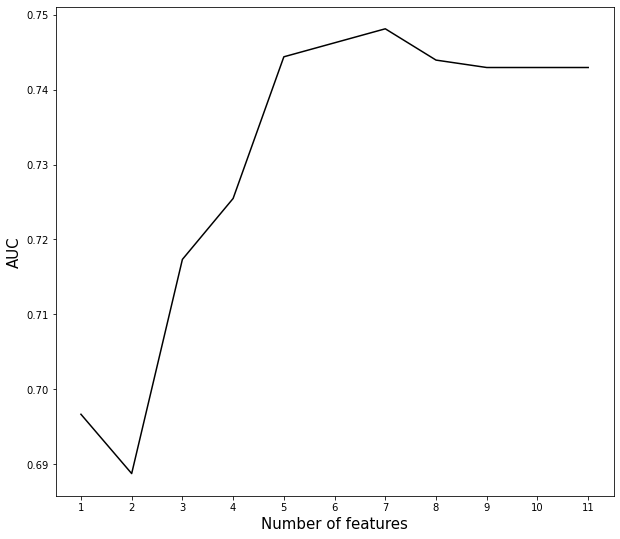

In [45]:
nb_features = np.arange(1, 12, 1)

fig, ax = plt.subplots(figsize=(10, 9))
ax.plot(nb_features, AUC, color='k')
ax.set_ylabel('AUC', fontsize=15)
ax.set_xlabel('Number of features', fontsize=15)
ax.set_xticks(nb_features)

In [46]:
import warnings
warnings.filterwarnings('ignore')

AUC=[]

# Fit model using each importance as a threshold
thresholds = sort(xgb.feature_importances_)
for thresh in thresholds:
    print(thresh)
    # select features using threshold
    selection = SelectFromModel(xgb, threshold=thresh, prefit=True)
    select_X_train = selection.transform(train)
    select_X_test = selection.transform(test)
    
    #Build matrix
    dmatrix_train = xgboost.DMatrix(select_X_train, label=train_labels)
    dmatrix_test = xgboost.DMatrix(select_X_test, label=test_labels)
    
    # train model
    selection_model = xgboost.train(params, dmatrix_train, num_boost_round=20000)

    # eval model
    predictions = selection_model.predict(dmatrix_test)
#     accuracy = accuracy_score(test_labels, predictions)
#     print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    AUC.append(metrics.roc_auc_score(y_true=test_labels, y_score=predictions))

0.0
0.0
0.012293207
0.016816588
0.017812949
0.041579004
0.06628417
0.066847116
0.12098423
0.19158445
0.46579832


In [47]:
AUC.reverse()
AUC

[0.7532965038248859,
 0.7673039329451621,
 0.7918285876128249,
 0.7979927872693909,
 0.8932372950013017,
 0.8951392042284516,
 0.8952436456602733,
 0.8975168268634695,
 0.8992609237068538,
 0.8983834025831928,
 0.8983834025831928]

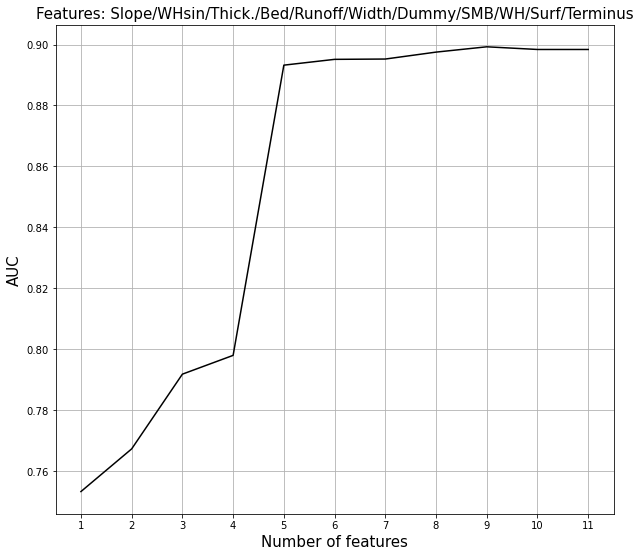

In [48]:
nb_features = np.arange(1, 12, 1)

fig, ax = plt.subplots(figsize=(10, 9))
ax.plot(nb_features, AUC, color='k')
ax.set_ylabel('AUC', fontsize=15)
ax.set_xlabel('Number of features', fontsize=15)
ax.set_xticks(nb_features)
ax.set_title('Features: Slope/WHsin/Thick./Bed/Runoff/Width/Dummy/SMB/WH/Surf/Terminus', fontsize=15)
ax.grid()
plt.savefig('/home/colili/Documents/PhD/project_john/Figure_produced/Raw/Features_elimination.pdf', format='pdf', bbox_inches='tight')

In [49]:
# rfe = RFE(xgb,4)
# rfe = rfe.fit(train_reduced, train_labels)

# print(rfe.support_)
# print(rfe.ranking_)

In [50]:
# temp = pd.Series(rfe.support_,index = train_reduced.columns)
# selected_features_rfe = temp[temp==True].index
# print(selected_features_rfe)